# Basis and Spectrum Providers Demo

This notebook demonstrates the **composable basis and spectrum provider architecture** from `providers.py`. This module builds on top of function providers to create the **foundation for space-based computations**.

## Key Components Demonstrated:

### 🏗️ **Provider Architecture**
- **`EigenvalueProvider`** (ABC) - computes eigenvalues for operators
- **`BasisProvider`** - wraps IndexedFunctionProvider for spaces
- **`SpectrumProvider`** - combines basis + eigenvalue providers

### 🔧 **Concrete Implementations**
- **`FourierEigenvalueProvider`** - Laplacian eigenvalues for Fourier
- **`ZeroEigenvalueProvider`** - zero eigenvalues (L² projections)
- **`CustomEigenvalueProvider`** - user-defined eigenvalue arrays

### 🎯 **Key Features**
- **Composable Design**: Mix any function provider with any eigenvalue provider
- **Lazy Computation**: Functions and eigenvalues computed on-demand
- **Efficient Caching**: Automatic caching for repeated access
- **Space Integration**: Seamless integration with Lebesgue and SobolevSpace

Let's explore the complete ecosystem!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

# Core imports
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.lebesgue_space import Lebesgue

# Function providers (building blocks)
from pygeoinf.interval.function_providers import (
    FourierFunctionProvider,
    SplineFunctionProvider,
    DiscontinuousFunctionProvider,
    WaveletFunctionProvider
)

# Providers module (main focus)
from pygeoinf.interval.providers import (
    BasisProvider,
    SpectrumProvider,
    EigenvalueProvider,
    FourierEigenvalueProvider,
    ZeroEigenvalueProvider,
    CustomEigenvalueProvider
)

# Set up plotting
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Basis and Spectrum Providers Demo Setup Complete!")
print("🎯 Focus: providers.py - Composable basis and spectrum architecture")
print("🆕 Using Lebesgue spaces with basis providers")

✅ Basis and Spectrum Providers Demo Setup Complete!
🎯 Focus: providers.py - Composable basis and spectrum architecture
🆕 Using Lebesgue spaces with basis providers


## 1. Foundation: Space and Function Providers

First, let's set up the foundation with a space and some function providers.

In [2]:
# Create domain and space
domain = IntervalDomain(0, np.pi, name="Demo Domain [0,π]")

# Option 1: Create Lebesgue space with explicit basis (direct approach)
fourier_basis = [
    lambda x: np.ones_like(x) / np.sqrt(np.pi),      # constant
    lambda x: np.sqrt(2/np.pi) * np.cos(x),          # cos(x)
    lambda x: np.sqrt(2/np.pi) * np.sin(x),          # sin(x)
    lambda x: np.sqrt(2/np.pi) * np.cos(2*x),        # cos(2x)
    lambda x: np.sqrt(2/np.pi) * np.sin(2*x),        # sin(2x)
    lambda x: np.sqrt(2/np.pi) * np.cos(3*x),        # cos(3x)
    lambda x: np.sqrt(2/np.pi) * np.sin(3*x),        # sin(3x)
    lambda x: np.sqrt(2/np.pi) * np.cos(4*x),        # cos(4x)
]

space_direct = Lebesgue(8, domain, basis=fourier_basis)

print("=== Foundation Setup ===")
print(f"📐 Domain: {domain}")
print(f"📏 Domain length: {domain.length:.4f}")
print(f"🏠 Direct Lebesgue space: {space_direct.dim}-dimensional")

# Create function providers (the building blocks)
function_providers = {
    'fourier': FourierFunctionProvider(space_direct),
    'spline': SplineFunctionProvider(space_direct),
    'discontinuous': DiscontinuousFunctionProvider(space_direct, random_state=42),
    'wavelet': WaveletFunctionProvider(space_direct, wavelet_type='haar')
}

print("\n🔧 Function Providers Created:")
for name, provider in function_providers.items():
    provider_type = type(provider).__name__
    print(f"  📦 {name}: {provider_type}")

print("\n🎯 Approach Demonstrated:")
print("  ✅ Lebesgue space with explicit basis functions")
print("  ✅ Function providers built on top of Lebesgue space")
print("  ✅ BasisProvider will wrap these for dynamic basis definition")
print("\n💡 Next: Wrap these function providers with BasisProvider and SpectrumProvider!")

=== Foundation Setup ===
📐 Domain: [0.0, 3.141592653589793]
📏 Domain length: 3.1416
🏠 Direct Lebesgue space: 8-dimensional

🔧 Function Providers Created:
  📦 fourier: FourierFunctionProvider
  📦 spline: SplineFunctionProvider
  📦 discontinuous: DiscontinuousFunctionProvider
  📦 wavelet: WaveletFunctionProvider

🎯 Approach Demonstrated:
  ✅ Lebesgue space with explicit basis functions
  ✅ Function providers built on top of Lebesgue space
  ✅ BasisProvider will wrap these for dynamic basis definition

💡 Next: Wrap these function providers with BasisProvider and SpectrumProvider!


## 2. BasisProvider: Dynamic Basis Definition for Lebesgue Spaces

The `BasisProvider` wraps any `IndexedFunctionProvider` and enables **dynamic basis definition** for Lebesgue spaces. This offers two powerful approaches:

### 🎯 **Two Approaches to Lebesgue Spaces:**
1. **Direct Approach**: `Lebesgue(dim, domain, basis=list_of_callables)`
2. **Provider Approach**: `Lebesgue(dim, domain, basis='none')` + `BasisProvider`

### 🚀 **Key Advantages of BasisProvider:**
- **Lazy Evaluation**: Basis functions created on-demand
- **Flexibility**: Switch basis types without recreating spaces  
- **Composability**: Mix different function providers
- **Integration**: Seamless integration with Lebesgue space methods

In [3]:
print("=== BasisProvider with Lebesgue Spaces ===")

# Create basis providers by wrapping function providers
basis_providers = {}
for name, func_provider in function_providers.items():
    if hasattr(func_provider, 'get_function_by_index'):  # IndexedFunctionProvider
        basis_provider = BasisProvider(space_direct, func_provider)
        basis_providers[name] = basis_provider
        print(f"✅ Created BasisProvider for {name}: {type(func_provider).__name__}")

print(f"\n📊 Created {len(basis_providers)} basis providers")

# Demonstrate BasisProvider interface with Lebesgue space
fourier_basis = basis_providers['fourier']
print("\n🧪 Testing BasisProvider Interface (Fourier + Lebesgue):")

# 1. Length and indexing
print(f"  📏 Length: len(fourier_basis) = {len(fourier_basis)}")
print(f"  📐 Lebesgue space dimension: {fourier_basis.space.dim}")

# 2. Index access
func_0 = fourier_basis[0]
func_3 = fourier_basis.get_basis_function(3)
print(f"  📈 Index access: fourier_basis[0] = {func_0.name}")
print(f"  📈 Method access: get_basis_function(3) = {func_3.name}")

# 3. Demonstrate basis function integration with Lebesgue space
print("\n🔄 BasisProvider → Lebesgue Space Integration:")
x_test = np.linspace(0, np.pi, 100)

# Compare basis functions from direct Lebesgue space vs BasisProvider
print("  Comparing basis functions:")
for i in range(min(3, len(fourier_basis))):
    # Direct from Lebesgue space
    direct_func = space_direct.get_basis_function(i)
    direct_vals = direct_func(x_test)

    # From BasisProvider
    provider_func = fourier_basis[i]
    provider_vals = np.array([provider_func.evaluate(x) for x in x_test])

    # Check if they match (allowing for normalization differences)
    correlation = np.corrcoef(direct_vals, provider_vals)[0, 1]
    print(f"    φ_{i}: Direct vs Provider correlation = {correlation:.6f}")

# 4. Show how BasisProvider can dynamically create basis for Lebesgue space
print("\n🚀 Dynamic Basis Creation for Lebesgue Space:")

# Create a new Lebesgue space without predefined basis
empty_space = Lebesgue(6, domain, basis='none')
print(f"  Empty Lebesgue space created: {empty_space.dim}D")

# Use different providers to create different basis types
spline_provider = SplineFunctionProvider(empty_space)
spline_basis_provider = BasisProvider(empty_space, spline_provider)

print(f"  Spline BasisProvider created for empty space")
print(f"  Available basis functions: {len(spline_basis_provider)}")

# Demonstrate that the same space can work with different basis types
print("\n  First 3 spline basis functions:")
for i in range(min(3, len(spline_basis_provider))):
    spline_func = spline_basis_provider[i]
    print(f"    φ_{i}: {spline_func.name}")

# 5. Error handling
print("\n  🚨 Error handling:")
try:
    bad_func = fourier_basis[100]  # Out of range
except IndexError as e:
    print(f"    ✅ IndexError caught: {e}")

print("\n✅ BasisProvider enables dynamic basis definition for Lebesgue spaces")
print("✅ Same Lebesgue space can use different basis types through providers")
print("✅ Seamless integration between provider-based and direct basis approaches")

=== BasisProvider with Lebesgue Spaces ===
✅ Created BasisProvider for fourier: FourierFunctionProvider
✅ Created BasisProvider for spline: SplineFunctionProvider
✅ Created BasisProvider for wavelet: WaveletFunctionProvider

📊 Created 3 basis providers

🧪 Testing BasisProvider Interface (Fourier + Lebesgue):
  📏 Length: len(fourier_basis) = 8
  📐 Lebesgue space dimension: 8
  📈 Index access: fourier_basis[0] = fourier_const
  📈 Method access: get_basis_function(3) = fourier_cos_2

🔄 BasisProvider → Lebesgue Space Integration:
  Comparing basis functions:
    φ_0: Direct vs Provider correlation = 1.000000
    φ_1: Direct vs Provider correlation = 0.000000
    φ_2: Direct vs Provider correlation = 0.000000

🚀 Dynamic Basis Creation for Lebesgue Space:
  Empty Lebesgue space created: 6D
  Spline BasisProvider created for empty space
  Available basis functions: 6

  First 3 spline basis functions:
    φ_0: spline_0
    φ_1: spline_1
    φ_2: spline_2

  🚨 Error handling:

✅ BasisProvider 

## 2.5. Direct vs Provider Approach: Practical Comparison

Let's compare the two approaches for creating and using Lebesgue spaces with different basis types.

=== Direct vs Provider Approach: Practical Comparison ===
🎯 Creating 4D Lebesgue spaces with different basis types
📐 Domain: [0.0, 6.283185307179586]

1️⃣ DIRECT APPROACH: Explicit basis functions
  ✅ Trigonometric space: 4D
  ✅ Polynomial space: 4D

2️⃣ PROVIDER APPROACH: Dynamic basis through BasisProvider
  ✅ Fourier provider space: 4D with 4 basis functions
  ✅ Spline provider space: 4D with 4 basis functions

📊 Visual Comparison of Approaches:


/tmp/ipykernel_3707532/4138424622.py:121: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3707532/4138424622.py:121: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/users/scro4564/anaconda3/envs/inferences2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/users/scro4564/anaconda3/envs/inferences2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


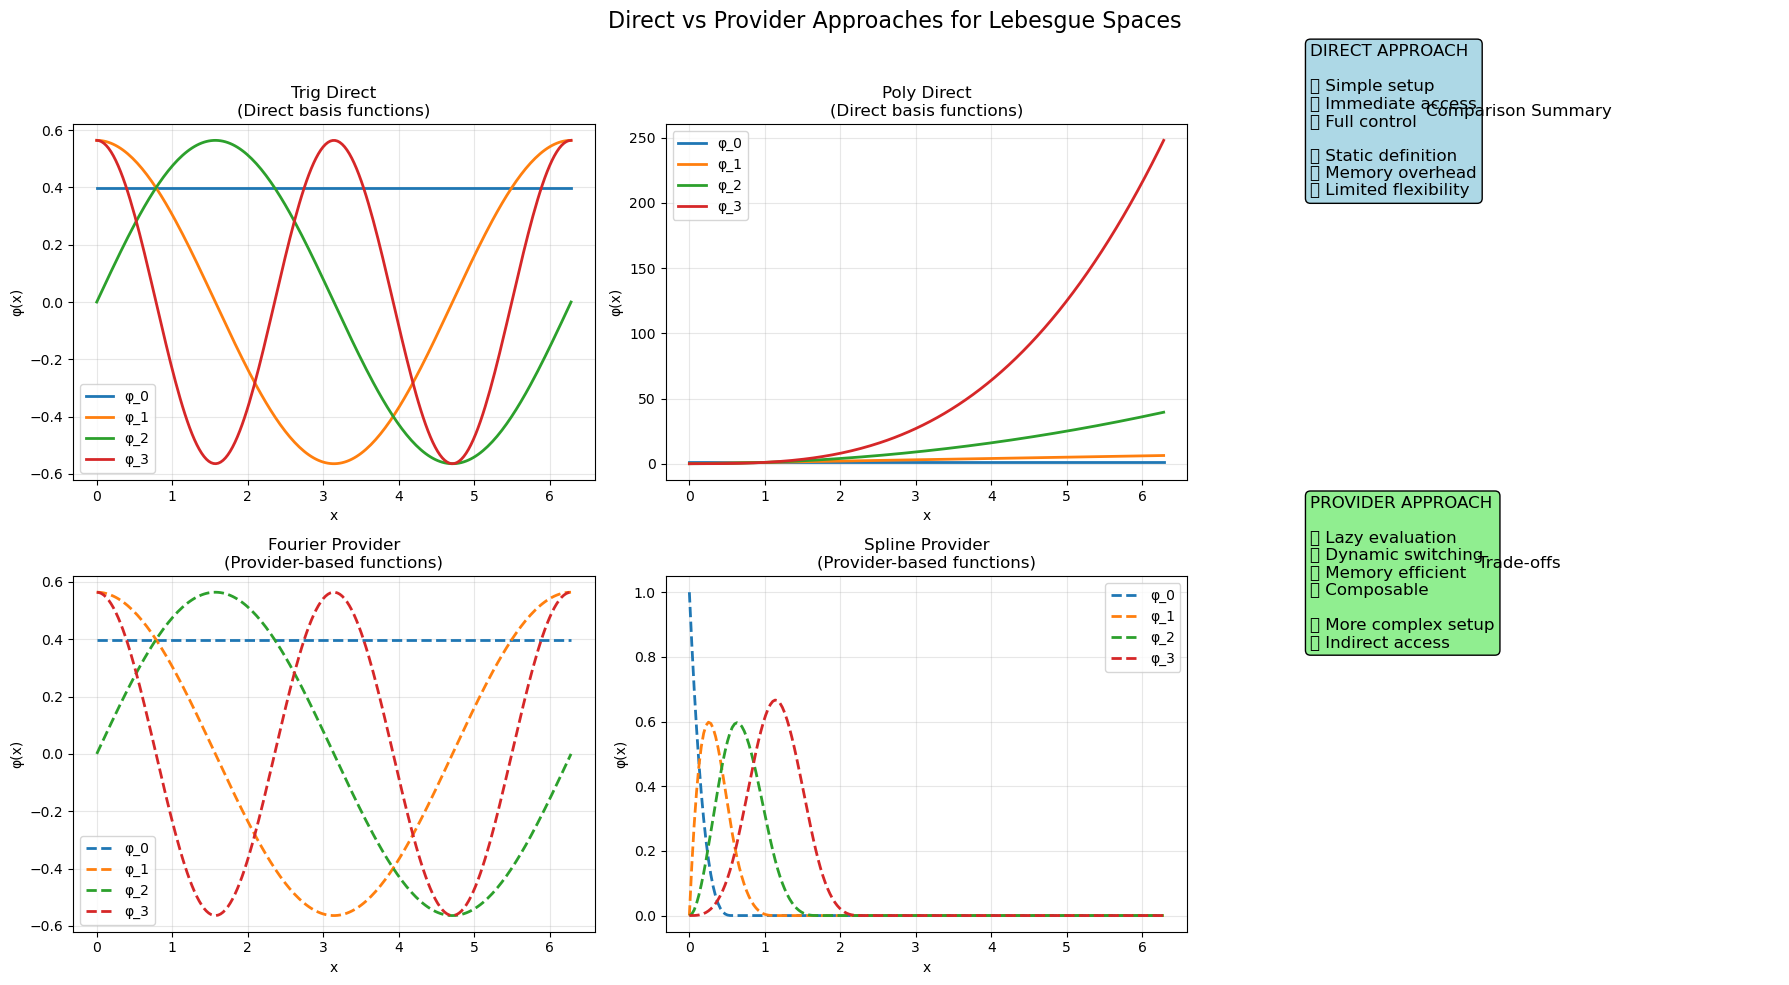


⚡ Performance & Flexibility Comparison:

📏 Memory Usage:
  Direct: All basis functions stored in memory
  Provider: Functions created on-demand

🔄 Flexibility:
  Direct: Fixed basis at creation time
  Provider: Can switch providers dynamically

🎯 Use Cases:
  Direct: When you have specific basis functions and need immediate access
  Provider: When you need flexibility, memory efficiency, or multiple basis types

✅ Both approaches integrate seamlessly with Lebesgue space methods
✅ Choice depends on specific use case requirements


In [4]:
print("=== Direct vs Provider Approach: Practical Comparison ===")

# Scenario: Create 4D Lebesgue spaces with different basis types

domain_test = IntervalDomain(0, 2*np.pi, name="Test Domain")
dim = 4

print("🎯 Creating 4D Lebesgue spaces with different basis types")
print(f"📐 Domain: {domain_test}")
print()

# Method 1: Direct Approach - Explicit basis functions
print("1️⃣ DIRECT APPROACH: Explicit basis functions")

# Trigonometric basis
trig_basis_direct = [
    lambda x: np.ones_like(x) / np.sqrt(2*np.pi),
    lambda x: np.cos(x) / np.sqrt(np.pi),
    lambda x: np.sin(x) / np.sqrt(np.pi),
    lambda x: np.cos(2*x) / np.sqrt(np.pi)
]
space_trig_direct = Lebesgue(dim, domain_test, basis=trig_basis_direct)

# Polynomial basis
poly_basis_direct = [
    lambda x: np.ones_like(x),
    lambda x: x,
    lambda x: x**2,
    lambda x: x**3
]
space_poly_direct = Lebesgue(dim, domain_test, basis=poly_basis_direct)

print(f"  ✅ Trigonometric space: {space_trig_direct.dim}D")
print(f"  ✅ Polynomial space: {space_poly_direct.dim}D")

# Method 2: Provider Approach - Dynamic basis through providers
print("\n2️⃣ PROVIDER APPROACH: Dynamic basis through BasisProvider")

# Create empty spaces (no predefined basis)
space_provider_1 = Lebesgue(dim, domain_test, basis='none')
space_provider_2 = Lebesgue(dim, domain_test, basis='none')

# Create function providers
fourier_provider = FourierFunctionProvider(space_provider_1)
spline_provider = SplineFunctionProvider(space_provider_2)

# Wrap with BasisProvider
basis_provider_fourier = BasisProvider(space_provider_1, fourier_provider)
basis_provider_spline = BasisProvider(space_provider_2, spline_provider)

print(f"  ✅ Fourier provider space: {space_provider_1.dim}D with {len(basis_provider_fourier)} basis functions")
print(f"  ✅ Spline provider space: {space_provider_2.dim}D with {len(basis_provider_spline)} basis functions")

# Comparison visualization
print("\n📊 Visual Comparison of Approaches:")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
x_plot = np.linspace(0, 2*np.pi, 200)

# Row 1: Direct approaches
spaces_direct = [
    ("Trig Direct", space_trig_direct),
    ("Poly Direct", space_poly_direct),
    ("", None)  # Empty for symmetry
]

# Row 2: Provider approaches
spaces_provider = [
    ("Fourier Provider", (space_provider_1, basis_provider_fourier)),
    ("Spline Provider", (space_provider_2, basis_provider_spline)),
    ("", None)  # Empty for symmetry
]

# Plot direct approaches
for i, (title, space) in enumerate(spaces_direct[:2]):
    ax = axes[0, i]
    if space is not None:
        for j in range(min(4, space.dim)):
            basis_func = space.get_basis_function(j)
            y_vals = basis_func(x_plot)
            ax.plot(x_plot, y_vals, label=f'φ_{j}', linewidth=2)

        ax.set_title(f'{title}\n(Direct basis functions)')
        ax.set_xlabel('x')
        ax.set_ylabel('φ(x)')
        ax.grid(True, alpha=0.3)
        ax.legend()

# Plot provider approaches
for i, (title, space_data) in enumerate(spaces_provider[:2]):
    ax = axes[1, i]
    if space_data is not None:
        space, provider = space_data
        for j in range(min(4, len(provider))):
            func = provider[j]
            # Evaluate function
            y_vals = np.array([func.evaluate(x) for x in x_plot])
            ax.plot(x_plot, y_vals, label=f'φ_{j}', linewidth=2, linestyle='--')

        ax.set_title(f'{title}\n(Provider-based functions)')
        ax.set_xlabel('x')
        ax.set_ylabel('φ(x)')
        ax.grid(True, alpha=0.3)
        ax.legend()

# Comparison summary in the third column
axes[0, 2].text(0.1, 0.8, "DIRECT APPROACH\n\n✅ Simple setup\n✅ Immediate access\n✅ Full control\n\n❌ Static definition\n❌ Memory overhead\n❌ Limited flexibility",
                fontsize=12, transform=axes[0, 2].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

axes[1, 2].text(0.1, 0.8, "PROVIDER APPROACH\n\n✅ Lazy evaluation\n✅ Dynamic switching\n✅ Memory efficient\n✅ Composable\n\n❌ More complex setup\n❌ Indirect access",
                fontsize=12, transform=axes[1, 2].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

axes[0, 2].set_title("Comparison Summary")
axes[1, 2].set_title("Trade-offs")
axes[0, 2].axis('off')
axes[1, 2].axis('off')

plt.suptitle('Direct vs Provider Approaches for Lebesgue Spaces', fontsize=16)
plt.tight_layout()
plt.show()

# Performance and flexibility comparison
print("\n⚡ Performance & Flexibility Comparison:")
print("\n📏 Memory Usage:")
print("  Direct: All basis functions stored in memory")
print("  Provider: Functions created on-demand")

print("\n🔄 Flexibility:")
print("  Direct: Fixed basis at creation time")
print("  Provider: Can switch providers dynamically")

print("\n🎯 Use Cases:")
print("  Direct: When you have specific basis functions and need immediate access")
print("  Provider: When you need flexibility, memory efficiency, or multiple basis types")

print("\n✅ Both approaches integrate seamlessly with Lebesgue space methods")
print("✅ Choice depends on specific use case requirements")

## 3. EigenvalueProvider: The Foundation of Spectral Methods

Eigenvalue providers compute eigenvalues for specific differential operators.

=== EigenvalueProvider Demonstration ===
🔧 Created EigenvalueProviders:
  📊 fourier_laplacian: FourierEigenvalueProvider
  📊 zero: ZeroEigenvalueProvider
  📊 custom_polynomial: CustomEigenvalueProvider
  📊 custom_exponential: CustomEigenvalueProvider

📈 Eigenvalue Sequences:
  fourier_laplacian:
    λ_0 = 0.000000
    λ_1 = 4.000000
    λ_2 = 4.000000
    λ_3 = 16.000000

  zero:
    λ_0 = 0.000000
    λ_1 = 0.000000
    λ_2 = 0.000000
    λ_3 = 0.000000

  custom_polynomial:
    λ_0 = 0.000000
    λ_1 = 1.000000
    λ_2 = 4.000000
    λ_3 = 9.000000

  custom_exponential:
    λ_0 = 1.000000
    λ_1 = 1.648721
    λ_2 = 2.718282
    λ_3 = 4.481689



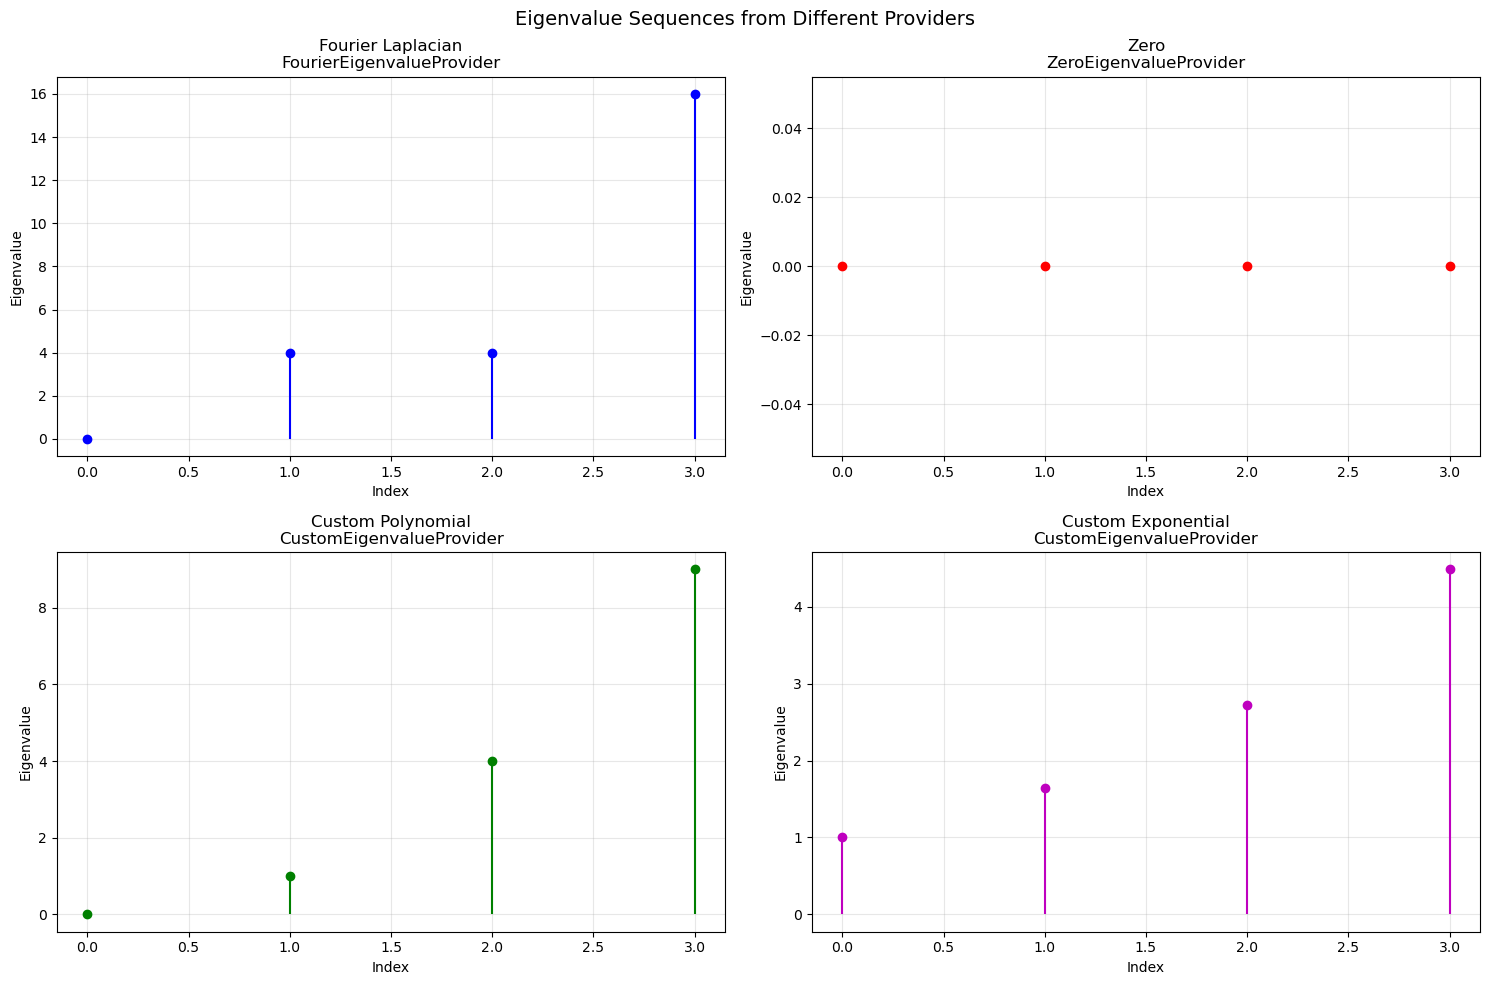

✅ EigenvalueProviders enable flexible spectral computations


In [5]:
print("=== EigenvalueProvider Demonstration ===")

# Create different eigenvalue providers
eigenvalue_providers = {
    'fourier_laplacian': FourierEigenvalueProvider(domain.length),
    'zero': ZeroEigenvalueProvider(),
    'custom_polynomial': CustomEigenvalueProvider([i**2 for i in range(space.dim)]),
    'custom_exponential': CustomEigenvalueProvider([np.exp(i/2) for i in range(space.dim)])
}

print("🔧 Created EigenvalueProviders:")
for name, provider in eigenvalue_providers.items():
    provider_type = type(provider).__name__
    print(f"  📊 {name}: {provider_type}")

# Compare eigenvalue sequences
print("\n📈 Eigenvalue Sequences:")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

colors = ['b', 'r', 'g', 'm']  # Use single-letter color codes
indices = np.arange(space.dim)

for i, (name, provider) in enumerate(eigenvalue_providers.items()):
    try:
        eigenvals = provider.get_eigenvalues(space.dim)

        axes[i].stem(indices, eigenvals, basefmt=' ',
                    linefmt=colors[i], markerfmt=f'{colors[i]}o')
        axes[i].set_title(f'{name.replace("_", " ").title()}\n{type(provider).__name__}')
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Eigenvalue')
        axes[i].grid(True, alpha=0.3)

        print(f"  {name}:")
        for j in range(min(5, len(eigenvals))):
            print(f"    λ_{j} = {eigenvals[j]:.6f}")
        print()

    except Exception as e:
        axes[i].text(0.5, 0.5, f'Error: {str(e)[:30]}...',
                    ha='center', va='center', transform=axes[i].transAxes)
        print(f"  ❌ {name}: {e}")

plt.suptitle('Eigenvalue Sequences from Different Providers', fontsize=14)
plt.tight_layout()
plt.show()

print("✅ EigenvalueProviders enable flexible spectral computations")

## 4. SpectrumProvider: Combining Functions and Eigenvalues

The `SpectrumProvider` combines any `IndexedFunctionProvider` with any `EigenvalueProvider`.

In [6]:
print("=== SpectrumProvider Demonstration ===")

# Create spectrum providers by combining function + eigenvalue providers
spectrum_providers = {}

# Standard combinations
combinations = [
    ('fourier_standard', 'fourier', 'fourier_laplacian'),
    ('fourier_zero', 'fourier', 'zero'),
    ('spline_polynomial', 'spline', 'custom_polynomial'),
    ('wavelet_exponential', 'wavelet', 'custom_exponential')
]

for name, func_name, eigen_name in combinations:
    try:
        func_provider = function_providers[func_name]
        eigen_provider = eigenvalue_providers[eigen_name]

        spectrum_provider = SpectrumProvider(space, func_provider, eigen_provider)
        spectrum_providers[name] = spectrum_provider

        print(f"✅ {name}: {type(func_provider).__name__} + {type(eigen_provider).__name__}")
    except Exception as e:
        print(f"❌ {name}: Failed - {e}")

print(f"\n📊 Created {len(spectrum_providers)} spectrum providers")

# Demonstrate SpectrumProvider interface
fourier_spectrum = spectrum_providers['fourier_standard']
print("\n🧪 Testing SpectrumProvider Interface (Fourier + Laplacian):")

# 1. Inherits BasisProvider functionality
print(f"  📏 Length: {len(fourier_spectrum)}")
print(f"  📈 Basis function[2]: {fourier_spectrum[2].name}")
print(f"  📈 Eigenfunction[2]: {fourier_spectrum.get_eigenfunction(2).name}")

# 2. Adds eigenvalue functionality
eigenval_2 = fourier_spectrum.get_eigenvalue(2)
print(f"  📊 Eigenvalue[2]: λ_2 = {eigenval_2:.6f}")

# 3. Bulk operations
all_eigenvals = fourier_spectrum.get_all_eigenvalues()
print(f"  📊 All eigenvalues: {len(all_eigenvals)} values")
print(f"     Range: [{all_eigenvals.min():.6f}, {all_eigenvals.max():.6f}]")

print("\n✅ SpectrumProvider = BasisProvider + eigenvalue computation")

=== SpectrumProvider Demonstration ===
✅ fourier_standard: FourierFunctionProvider + FourierEigenvalueProvider
✅ fourier_zero: FourierFunctionProvider + ZeroEigenvalueProvider
✅ spline_polynomial: SplineFunctionProvider + CustomEigenvalueProvider
✅ wavelet_exponential: WaveletFunctionProvider + CustomEigenvalueProvider

📊 Created 4 spectrum providers

🧪 Testing SpectrumProvider Interface (Fourier + Laplacian):
  📏 Length: 4
  📈 Basis function[2]: fourier_sin_1
  📈 Eigenfunction[2]: fourier_sin_1
  📊 Eigenvalue[2]: λ_2 = 4.000000
  📊 All eigenvalues: 4 values
     Range: [0.000000, 16.000000]

✅ SpectrumProvider = BasisProvider + eigenvalue computation
